<a href="https://colab.research.google.com/github/AristarkhovZakhar/deep_learning/blob/main/Medicine_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>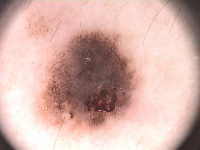</td><td>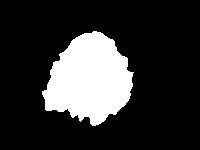</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
!wget -c https://www.dropbox.com/s/n01pfz8911vn4q1/PH2Dataset.rar 

--2022-12-05 19:31:34--  https://www.dropbox.com/s/n01pfz8911vn4q1/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6023:18::a27d:4312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/n01pfz8911vn4q1/PH2Dataset.rar [following]
--2022-12-05 19:31:34--  https://www.dropbox.com/s/raw/n01pfz8911vn4q1/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc55101250ad8fcb54b2608fd02a.dl.dropboxusercontent.com/cd/0/inline/ByFVmURBmUXmJgdY0X7ew2lhhHVQJCxjHSzvpUxqK-Q2Z2EyZTGP-0t7gnJDP4gJrAWMT0Gysp_FEZ37wXf1_7vsibqdSs8zYYLjsco5zn9THci96muQZvch15X6yfoMGnFlRI3lthJ40dyFKorcQj4Pmn8cwNL9yyYIX1Ej7WJs1w/file# [following]
--2022-12-05 19:31:35--  https://uc55101250ad8fcb54b2608fd02a.dl.dropboxusercontent.com/cd/0/inline/ByFVmURBmUXmJgdY0X7ew2lhhHVQJCxjHSzvpUxqK-Q2Z2EyZTGP-0t7gnJDP4gJrAWMT0G

In [ ]:
!ls

PH2Dataset.rar	sample_data


In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

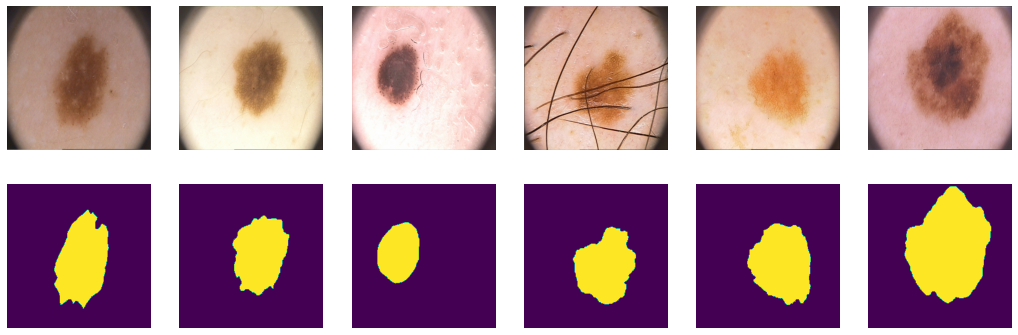

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

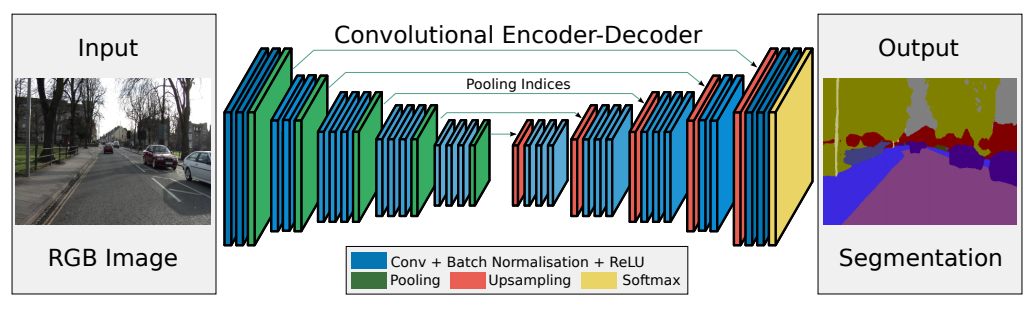

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(2, stride=2, return_indices=True)

        # bottleneck
        self.bottleneck_enc_conv = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.bottleneck_pool = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.bottleneck_upsample = nn.MaxUnpool2d(2, stride=2)
        self.bottleneck_dec_conv = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, stride=2)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample1 = nn.MaxUnpool2d(2, stride=2)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample2 = nn.MaxUnpool2d(2, stride=2)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample3 = nn.MaxUnpool2d(2, stride=2)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))
      
        # bottleneck
        b, b_ind = self.bottleneck_pool(self.bottleneck_enc_conv(e3))
        b = self.bottleneck_dec_conv(self.bottleneck_upsample(b, b_ind))
        
        # decoder
        d0 = self.dec_conv0(self.upsample0(b, ind3))
        d1 = self.dec_conv1(self.upsample1(d0, ind2))
        d2 = self.dec_conv2(self.upsample2(d1, ind1))
        d3 = self.dec_conv3(self.upsample3(d2, ind0))
        return d3


## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return iou.mean()

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:

class BCEWithLogitsLoss(nn.Module):
    def __init__(
        self,
        reduction: str = "mean"
    ):
        super().__init__()
        self.reduction = reduction

    def forward(self, y_pred: torch.Tensor, y_real: torch.Tensor) -> torch.Tensor:
        loss = y_pred.clamp(min=0) - y_real * y_pred + torch.log(1 + torch.exp(-torch.abs(y_pred)))

        if self.reduction == "mean":
            loss = loss.mean()

        if self.reduction == "sum":
            loss = loss.sum()

        return loss



     

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, 
          optimizer,
          scheduler,
          loss_fn, 
          data_tr, 
          data_val,
          epochs: int = 100, 
          device: str = 'cuda',
          model_name: str = 'model',
          threshold: float = 0.5):
    
    X_val, Y_val = next(iter(data_val))
    train_losses, val_losses, train_iou, val_iou = [], [], [], []

    optimizer_state = optimizer.state_dict()
    model_state = model.state_dict()
    min_loss = 100.0
    best_epoch = 0
    best_iou = 0.0


    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch + 1, epochs))

        avg_train_loss = 0.0
        avg_train_iou = 0.0
        model.train()
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            
            optimizer.zero_grad()

            # forward
            logits = model(X_batch)
            loss = loss_fn(logits, Y_batch)
            predictions = (torch.sigmoid(logits) > threshold).float()
            cur_train_iou = iou_pytorch(predictions, Y_batch).item()

            loss.backward()
            optimizer.step()

            # calculate loss to show the user
            avg_train_loss += loss / len(data_tr)
            avg_train_iou += cur_train_iou / len(data_tr)

        toc = time()
        avg_train_loss = avg_train_loss.detach().cpu()

        # update train history
        train_losses.append(avg_train_loss)
        train_iou.append(avg_train_iou)

        # show intermediate results
        model.eval()  # testing mode
        avg_val_loss = 0
        avg_val_iou = 0
        with torch.no_grad():
            Y_hat = torch.sigmoid(model(X_val.to(device))).detach().cpu()      
            
            for X_batch, Y_batch in data_val:
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)

                logits = model(X_batch)
                loss = loss_fn(logits, Y_batch)
                avg_val_loss += loss / len(data_val)
                
                predictions = (torch.sigmoid(logits) > threshold).float()
                cur_val_iou = iou_pytorch(predictions, Y_batch).item()
                avg_val_iou += cur_val_iou / len(data_val)

            avg_val_loss = avg_val_loss.cpu()
            val_losses.append(avg_val_loss)
            val_iou.append(avg_val_iou)
        
        # update best model metadata
        if avg_val_loss < min_loss:
            model_state = model.state_dict()
            min_loss = avg_val_loss
            best_epoch = epoch
            best_iou = avg_val_iou
            optimizer_state = optimizer.state_dict()

        scheduler.step()

        # Visualize tools
        clear_output(wait=True)
        Y_val = Y_val.squeeze(1).byte()
        for k in range(6):
            plt.subplot(4, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(4, 6, k+7)
            plt.imshow(Y_val[k].numpy(), cmap='gray')
            plt.title('Ground truth')
            plt.axis('off')

            plt.subplot(4, 6, k+13)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Сonfidence')
            plt.axis('off')

            plt.subplot(4, 6, k+19)
            plt.imshow((Y_hat[k, 0] > threshold).float(), cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - train_loss: %f | val_loss %f | val_iou %f' % (epoch +1 , epochs, avg_train_loss, avg_val_loss, avg_val_iou))
        plt.show()


    checkpoint_name = f'{model_name}_{best_epoch}_epoch.pth'
    torch.save({
        'model_state': model_state,
        'optimizer_state': optimizer_state,
        'model_loss': min_loss,
        'model_iou': best_iou,
        'epoch': best_epoch
    }, checkpoint_name)

    result_dict = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'model_name': checkpoint_name,
        "train_iou": train_iou,
        'val_iou': val_iou
    }

    del X_batch
    del Y_batch
    del logits
    del predictions
    del loss
    torch.cuda.empty_cache()

    return result_dict



## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:

def predict(model, data, threshold: float = 0.5):
    model.eval()  # testing mode
    with torch.no_grad():
        Y_pred = [(torch.sigmoid(model(X_batch.to(device))) > threshold).float().cpu() for X_batch, _ in data]
    return Y_pred


In [ ]:

def score_model(model, metric, data, threshold: float = 0.5):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_label = Y_label.to(device)
        with torch.no_grad():
            Y_pred = (torch.sigmoid(model(X_batch)) > threshold).float()
            scores += metric(Y_pred, Y_label) / len(data)

    del X_batch
    del Y_label
    del Y_pred
    torch.cuda.empty_cache()

    return scores


## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
model = SegNet().to(device)

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 17           |        cudaMalloc retries: 18        |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   13226 MB |   13228 MB |  106801 GB |  106788 GB |
|       from large pool |   13150 MB |   13152 MB |  106784 GB |  106771 GB |
|       from small pool |      76 MB |      78 MB |      17 GB |      16 GB |
|---------------------------------------------------------------------------|
| Active memory         |   13226 MB |   13228 MB |  106801 GB |  106788 GB |
|       from large pool |   13150 MB |   13152 MB |  106784 GB |

In [ ]:
import torch.optim as optim

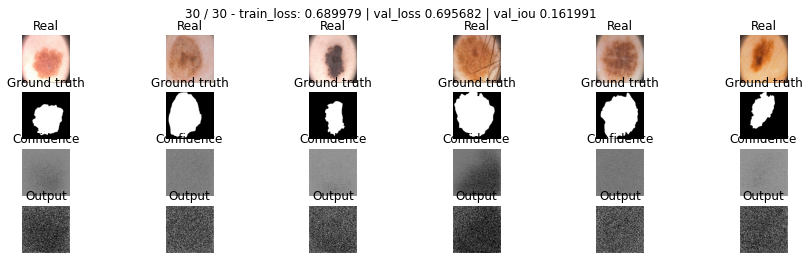

In [ ]:
max_epochs = 30


SegNet_BCE = SegNet().to(device)

optimizer = optim.Adam(SegNet_BCE.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = BCEWithLogitsLoss()
segnet_bce_history = train(model, 
                           optimizer, 
                           scheduler,
                           criterion,
                           data_tr, 
                           data_val,
                           max_epochs,
                           device=device,
                           model_name='segnet_bce')

In [ ]:

best_checkpoint = torch.load(segnet_bce_history['model_name'])

In [ ]:

SegNet_BCE.load_state_dict(best_checkpoint['model_state'])
segnet_bce_test_iou = score_model(SegNet_BCE, iou_pytorch, data_ts).cpu().item()
segnet_bce_history['test'] = segnet_bce_test_iou


In [ ]:

min_val_loss, max_val_iou, best_epoch = best_checkpoint['model_loss'], best_checkpoint['model_iou'], best_checkpoint['epoch']
print(f"Best Segnet BCE val loss: {min_val_loss}")
print(f"Best SegNet BCE val IoU: {max_val_iou}")
print(f"Best SegNet BCE epoch: {best_epoch}")
print(f"Best SegNet BCE test IoU: {segnet_bce_test_iou}")

Best Segnet BCE val loss: 0.6878801584243774
Best SegNet BCE val IoU: 0.17389198392629623
Best SegNet BCE epoch: 14
Best SegNet BCE test IoU: 0.16566216945648193


In [ ]:

def plot_history(history, min_val_loss: float, max_val_iou: float, best_epoch: int, title: str):
    f, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].plot(history['train_losses'], label='train_loss')
    ax[0].plot(history['val_losses'], label='val_loss')
    # отмечаем значения на той эпохе, где был достигнут минимальный валидационный лосс
    ax[0].hlines(y=min_val_loss, xmin=0, xmax=best_epoch, color='green', label='best epoch value', linestyles='--')
    ax[0].vlines(x=best_epoch, ymin=0, ymax=min_val_loss, color='green', linestyles='--')
    ax[0].set_title('Loss')

    ax[1].plot(history['train_iou'], label='train_score')
    ax[1].plot(history['val_iou'], label='val_score')
    # отмечаем значения на той эпохе, где был достигнут минимальный валидационный лосс
    ax[1].hlines(y=max_val_iou, xmin=0, xmax=best_epoch, color='red', label='best epoch value', linestyles='--')
    ax[1].vlines(x=best_epoch, ymin=0, ymax=max_val_iou, color='red', linestyles='--')
    ax[1].set_title('IoU')
    plt.suptitle(title)
    for col in ax:
        col.grid(True)
        col.legend()


In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 10           |        cudaMalloc retries: 10        |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    1215 MB |   11398 MB |   45948 GB |   45947 GB |
|       from large pool |    1172 MB |   11354 MB |   45939 GB |   45938 GB |
|       from small pool |      43 MB |      71 MB |       8 GB |       8 GB |
|---------------------------------------------------------------------------|
| Active memory         |    1215 MB |   11398 MB |   45948 GB |   45947 GB |
|       from large pool |    1172 MB |   11354 MB |   45939 GB |

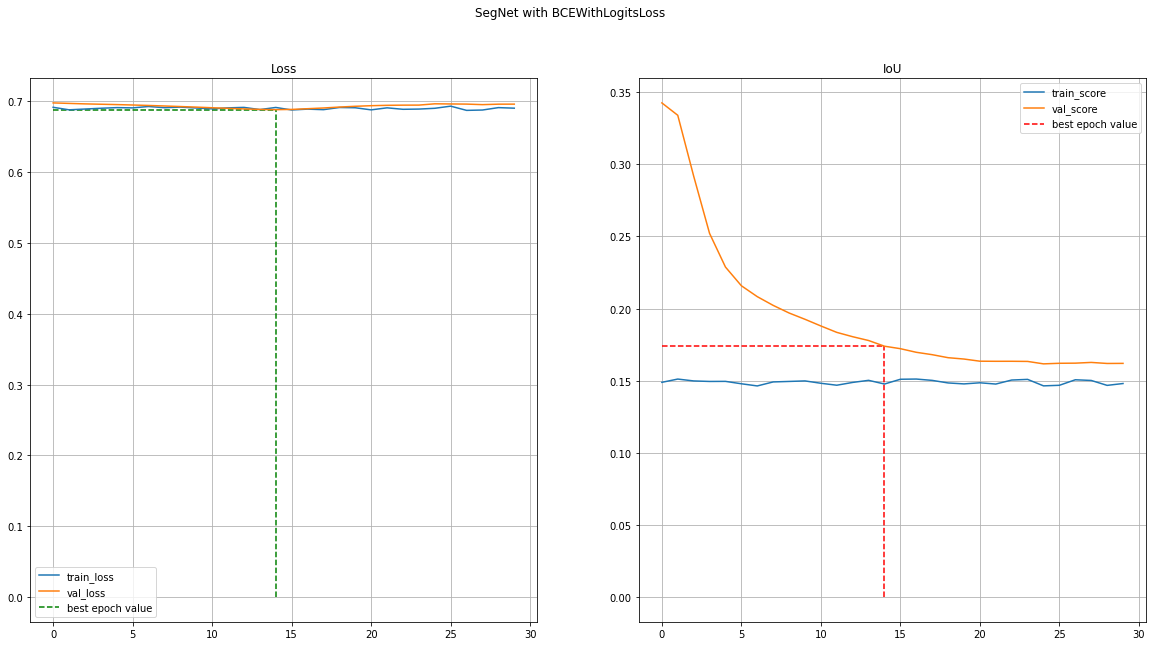

In [ ]:
plot_history(segnet_bce_history, min_val_loss, max_val_iou, best_epoch, 'SegNet with BCEWithLogitsLoss')


Ответьте себе на вопрос: не переобучается ли моя модель?

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
torch.cuda.empty_cache()

In [ ]:

class DiceLoss(nn.Module):
    def __init__(
        self,
        eps: float = 1e-8
    ):
        super().__init__()
        self.eps = eps

    def forward(self, y_pred: torch.Tensor, y_real: torch.Tensor) -> torch.Tensor:
        y_pred = torch.sigmoid(y_pred.squeeze(1))
        y_real = y_real.squeeze(1)

        num = 2.0 * (y_real * y_pred).sum((1, 2))
        den = (y_real + y_pred).sum((1, 2))
        res = 1 -  ((num + self.eps) / (den + self.eps)).sum() / y_real.size(0)
        return res 


     

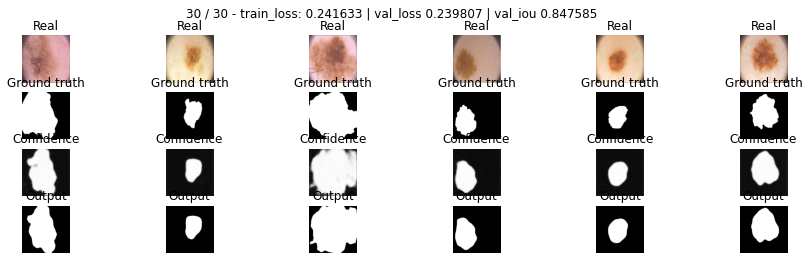

In [ ]:
SegNet_Dice = SegNet().to(device)

optimizer = optim.Adam(SegNet_Dice.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = DiceLoss()
segnet_dice_history = train(SegNet_Dice, 
                           optimizer, 
                           scheduler,
                           criterion,
                           data_tr, 
                           data_val,
                           max_epochs,
                           device=device,
                           model_name='segnet_dice')


Проводим тестирование:

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 10           |        cudaMalloc retries: 10        |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    1671 MB |   11398 MB |   53654 GB |   53652 GB |
|       from large pool |    1619 MB |   11354 MB |   53644 GB |   53643 GB |
|       from small pool |      52 MB |      71 MB |       9 GB |       9 GB |
|---------------------------------------------------------------------------|
| Active memory         |    1671 MB |   11398 MB |   53654 GB |   53652 GB |
|       from large pool |    1619 MB |   11354 MB |   53644 GB |

In [ ]:
best_checkpoint = torch.load(segnet_dice_history['model_name'])

In [ ]:

SegNet_Dice.load_state_dict(best_checkpoint['model_state'])
segnet_dice_test_iou = score_model(SegNet_Dice, iou_pytorch, data_ts).cpu().item()
segnet_dice_history['test'] = segnet_dice_test_iou


In [ ]:
min_val_loss, max_val_iou, best_epoch = best_checkpoint['model_loss'], best_checkpoint['model_iou'], best_checkpoint['epoch']
print(f"Best Segnet Dice val loss: {min_val_loss}")
print(f"Best SegNet Dice val IoU: {max_val_iou}")
print(f"Best SegNet Dice epoch: {best_epoch}")
print(f"Best SegNet Dice test IoU: {segnet_dice_test_iou}")


Best Segnet Dice val loss: 0.23980724811553955
Best SegNet Dice val IoU: 0.8475849330425262
Best SegNet Dice epoch: 29
Best SegNet Dice test IoU: 0.8411496877670288


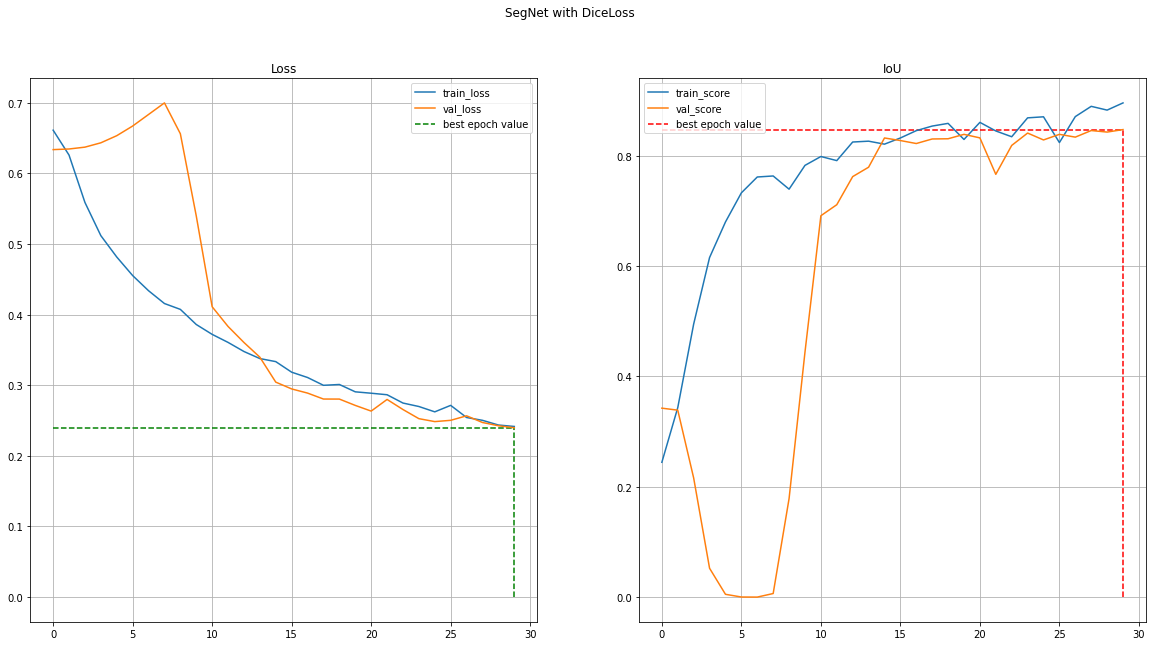

In [ ]:

plot_history(segnet_dice_history, min_val_loss, max_val_iou, best_epoch, 'SegNet with DiceLoss')


[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:

class FocalLoss(nn.Module):
    def __init__(
        self,
        eps: float = 1e-8,
        gamma: float = 2.0,
        reduction: str = "mean"
    ):
        super().__init__()
        self.eps = eps
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, y_pred: torch.Tensor, y_real: torch.Tensor) -> torch.Tensor:
        y_pred = torch.clamp(torch.sigmoid(y_pred), min=self.eps, max=1 - self.eps)
        loss = (1 - y_pred) ** self.gamma * y_real * torch.log(y_pred) + (1 - y_real) * torch.log(1 - y_pred)

        if self.reduction == "mean":
            loss = -loss.mean()

        if self.reduction == "sum":
            loss = -loss.sum()

        return loss


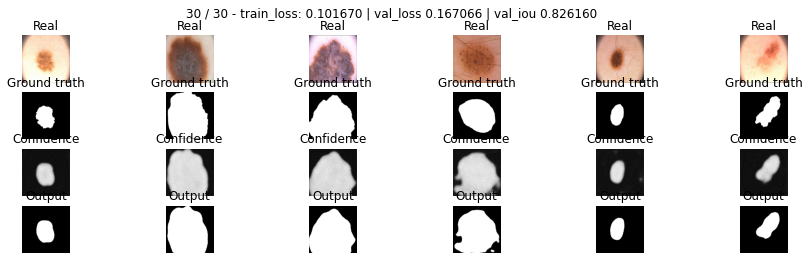

In [ ]:
max_epochs = 30
SegNet_Focal = SegNet().to(device)

optimizer = optim.Adam(SegNet_Focal.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = FocalLoss()
segnet_focal_history = train(SegNet_Focal, 
                           optimizer, 
                           scheduler,
                           criterion,
                           data_tr, 
                           data_val,
                           max_epochs,
                           device=device,
                           model_name='segnet_focal')

In [ ]:

best_checkpoint = torch.load(segnet_focal_history['model_name'])

In [ ]:

SegNet_Focal.load_state_dict(best_checkpoint['model_state'])
segnet_focal_test_iou = score_model(SegNet_Focal, iou_pytorch, data_ts).cpu().item()
segnet_focal_history['test'] = segnet_focal_test_iou



In [ ]:
min_val_loss, max_val_iou, best_epoch = best_checkpoint['model_loss'], best_checkpoint['model_iou'], best_checkpoint['epoch']
print(f"Best Segnet Focal val loss: {min_val_loss}")
print(f"Best SegNet Focal val IoU: {max_val_iou}")
print(f"Best SegNet Focal epoch: {best_epoch}")
print(f"Best SegNet Focal test IoU: {segnet_focal_test_iou}")


Best Segnet Focal val loss: 0.15459910035133362
Best SegNet Focal val IoU: 0.8254125714302063
Best SegNet Focal epoch: 29
Best SegNet Focal test IoU: 0.8186619281768799


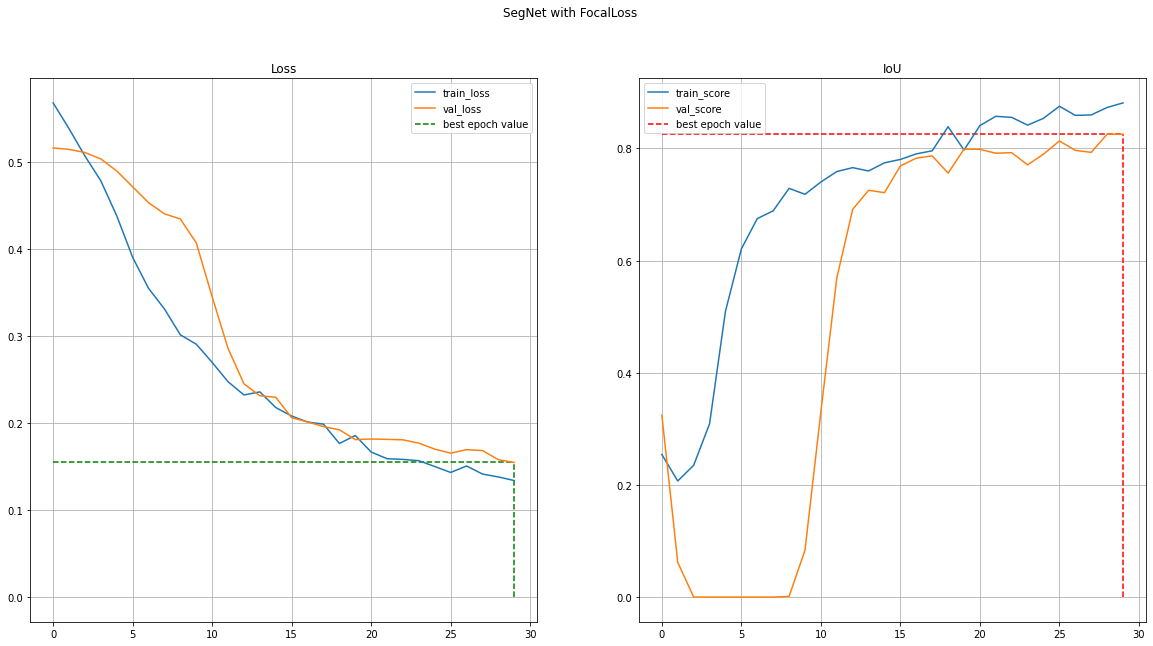

In [ ]:

plot_history(segnet_focal_history, min_val_loss, max_val_iou, best_epoch, 'SegNet with FocalLoss')


----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [ ]:
class JaccardLoss(nn.Module):
    def __init__(
        self,
        eps: float = 1e-8
    ):
        super().__init__()
        self.eps = eps

    def forward(self, y_pred: torch.Tensor, y_real: torch.Tensor) -> torch.Tensor:
        y_pred = torch.sigmoid(y_pred.squeeze(1))
        y_real = y_real.squeeze(1)

        num = 2.0 * (y_real * y_pred).sum((1, 2))
        den = (y_real + y_pred).sum((1, 2))
        dice = 1 -  ((num + self.eps) / (den + self.eps)).sum() / y_real.size(0)
        res = dice / (2 - dice)
        return res 

In [ ]:
class SoftBCEWithLogitsLoss(BCEWithLogitsLoss):
    def __init__(
        self,
        reduction: str = "mean",
        smooth_factor: float = 0.1,
    ):
        super().__init__(reduction)
        self.smooth_factor = smooth_factor

    def forward(self, y_pred: torch.Tensor, y_real: torch.Tensor) -> torch.Tensor:
        soft_targets = (1 - y_real) * self.smooth_factor + y_real * (1 - self.smooth_factor)
        loss = super().forward(y_pred, soft_targets)

        return loss

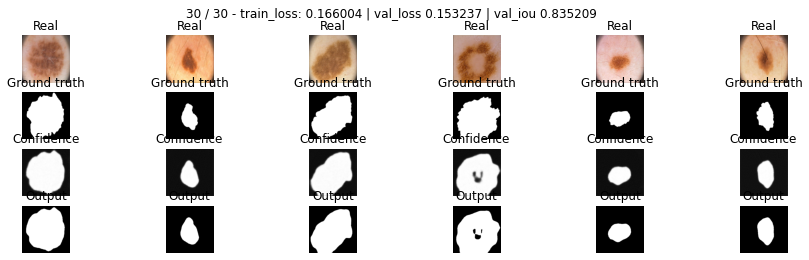

In [ ]:
SegNet_Jaccard = SegNet().to(device)

optimizer = optim.Adam(SegNet_Jaccard.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion =  JaccardLoss()
segnet_jaccard_history = train(SegNet_Jaccard, 
                           optimizer, 
                           scheduler,
                           criterion,
                           data_tr, 
                           data_val,
                           max_epochs,
                           device=device,
                           model_name='segnet_softbce')


Best SegNet_Jaccard val loss: 0.1532372236251831
Best SegNet_Jaccard val IoU: 0.8352090716362
Best SegNet_Jaccard epoch: 29
Best SegNet_Jaccard test IoU: 0.8285143375396729


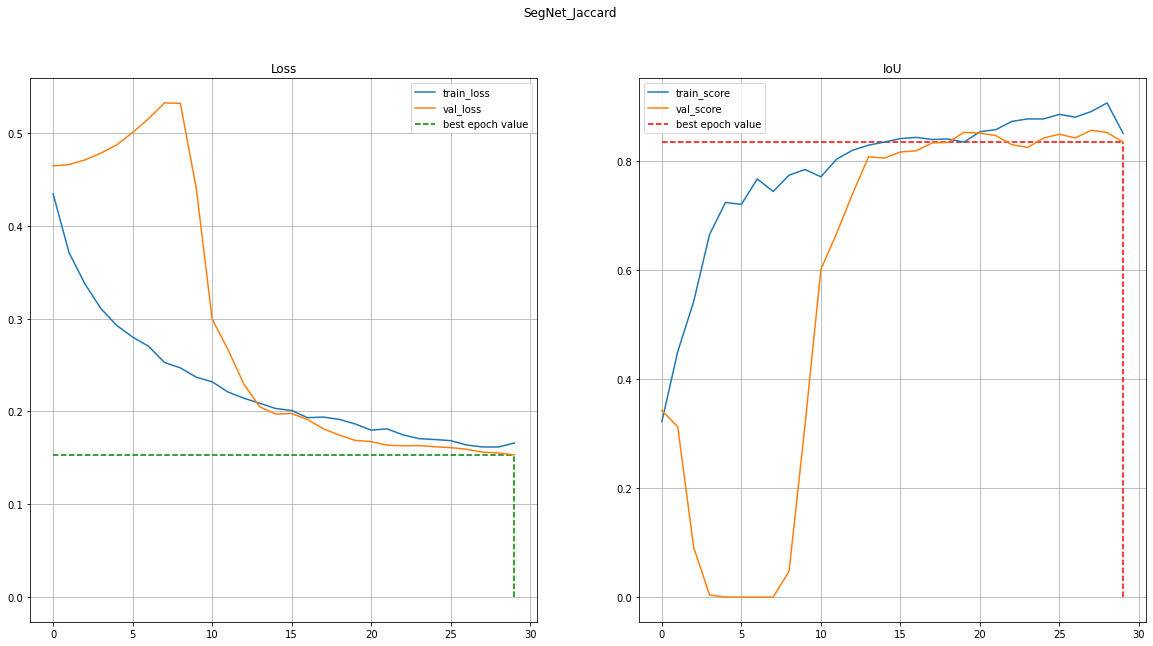

In [ ]:
best_checkpoint = torch.load(segnet_jaccard_history['model_name'])

SegNet_Jaccard.load_state_dict(best_checkpoint['model_state'])
segnet_jacc_test_iou = score_model(SegNet_Jaccard, iou_pytorch, data_ts).cpu().item()
segnet_jaccard_history['test'] = segnet_jacc_test_iou


     

min_val_loss, max_val_iou, best_epoch = best_checkpoint['model_loss'], best_checkpoint['model_iou'], best_checkpoint['epoch']
print(f"Best SegNet_Jaccard val loss: {min_val_loss}")
print(f"Best SegNet_Jaccard val IoU: {max_val_iou}")
print(f"Best SegNet_Jaccard epoch: {best_epoch}")
print(f"Best SegNet_Jaccard test IoU: {segnet_jacc_test_iou}")

plot_history(segnet_jaccard_history, min_val_loss, max_val_iou, best_epoch, 'SegNet_Jaccard')

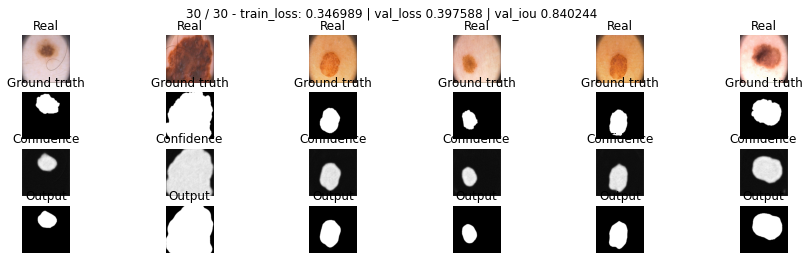

In [ ]:
max_epochs = 30
SegNet_SoftBCE = SegNet().to(device)
optimizer = optim.Adam(SegNet_SoftBCE.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = SoftBCEWithLogitsLoss()
segnet_softbce_history = train(SegNet_SoftBCE, 
                           optimizer, 
                           scheduler,
                           criterion,
                           data_tr, 
                           data_val,
                           max_epochs,
                           device=device,
                           model_name='segnet_softbce')



Best Segnet SoftBCE val loss: 0.3973087668418884
Best SegNet SoftBCE val IoU: 0.8393539190292358
Best SegNet SoftBCE epoch: 28
Best SegNet SoftBCE test IoU: 0.8453007936477661


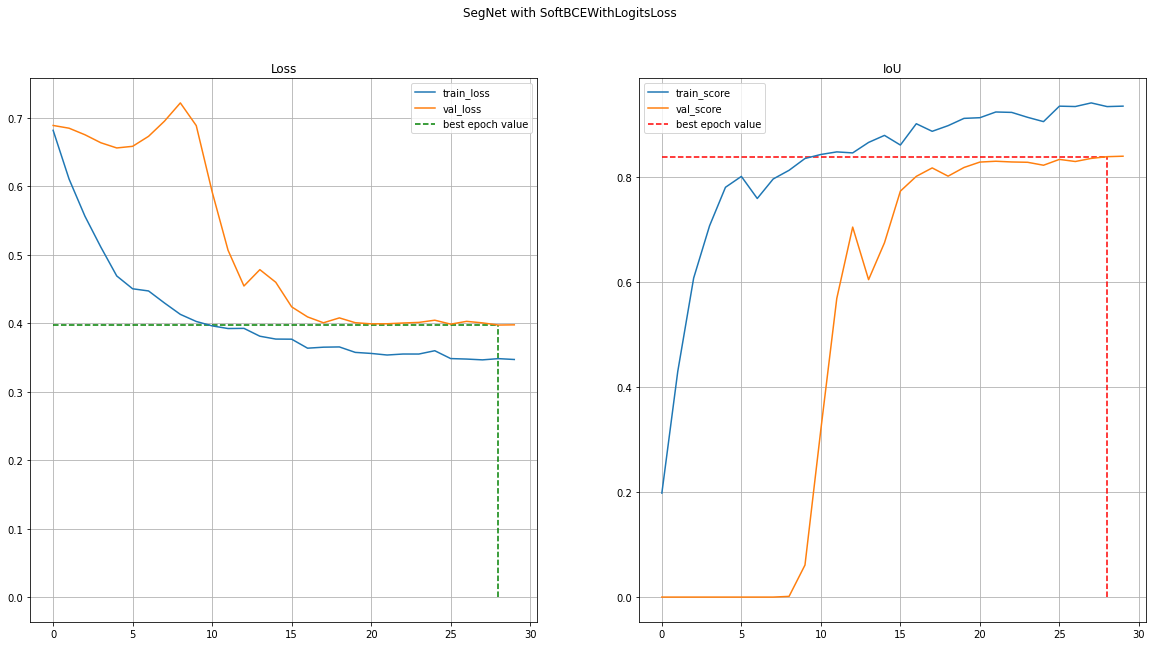

In [ ]:
best_checkpoint = torch.load(segnet_softbce_history['model_name'])


     

SegNet_SoftBCE.load_state_dict(best_checkpoint['model_state'])
segnet_softbce_test_iou = score_model(SegNet_SoftBCE, iou_pytorch, data_ts).cpu().item()
segnet_softbce_history['test'] = segnet_softbce_test_iou


     

min_val_loss, max_val_iou, best_epoch = best_checkpoint['model_loss'], best_checkpoint['model_iou'], best_checkpoint['epoch']
print(f"Best Segnet SoftBCE val loss: {min_val_loss}")
print(f"Best SegNet SoftBCE val IoU: {max_val_iou}")
print(f"Best SegNet SoftBCE epoch: {best_epoch}")
print(f"Best SegNet SoftBCE test IoU: {segnet_softbce_test_iou}")


plot_history(segnet_softbce_history, min_val_loss, max_val_iou, best_epoch, 'SegNet with SoftBCEWithLogitsLoss')

-----------------------------------------------------------------------------------------

# U-Net


[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

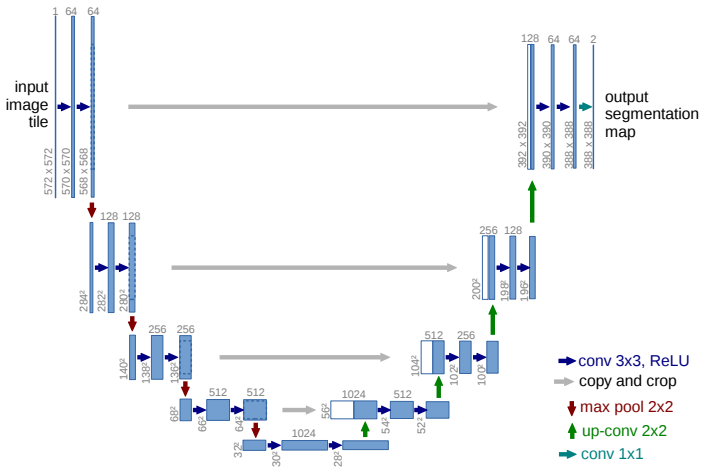

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(2, 2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2)  # 128 -> 64 
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2)  # 64 -> 32 
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        # bottleneck
        self.bottleneck_pool = nn.MaxPool2d(2, 2)  # 32 -> 16 
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        ) 
        self.bottleneck_upconv = nn.Upsample(scale_factor=2)  # 16 -> 32
        
        # decoder (upsampling)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        ) 
        self.upsample1 = nn.Upsample(scale_factor=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        ) 
        self.upsample2 = nn.Upsample(scale_factor=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        ) 
        self.upsample3 = nn.Upsample(scale_factor=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=1)
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        p0 = self.pool0(e0)
        
        e1 = self.enc_conv1(p0)
        p1 = self.pool1(e1)
        
        e2 = self.enc_conv2(p1)
        p2 = self.pool2(e2)
        
        e3 = self.enc_conv3(p2)
        p3 = self.bottleneck_pool(e3)
        
        # bottleneck
        b = self.bottleneck_upconv(self.bottleneck_conv(p3))
        
        # decoder
        d0 = self.upsample1(self.dec_conv0(torch.cat([b, e3], dim=1)))
        d1 = self.upsample2(self.dec_conv1(torch.cat([d0, e2], dim=1)))
        d2 = self.upsample3(self.dec_conv2(torch.cat([d1, e1], dim=1)))
        d3 = self.dec_conv3(torch.cat([d2, e0], dim=1))  # no activation
        return d3


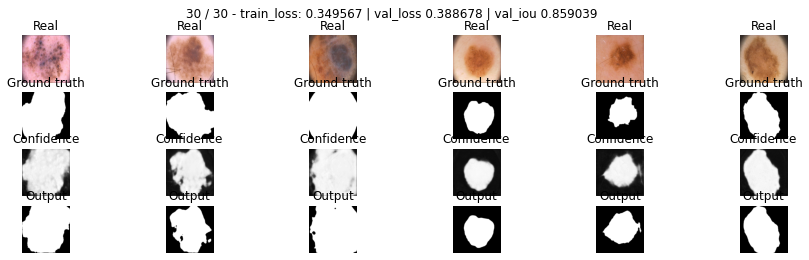

In [ ]:
max_epochs = 30
UNet_SoftBCE = UNet().to(device)

optimizer = optim.Adam(UNet_SoftBCE.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = SoftBCEWithLogitsLoss()
unet_SoftBCE_history = train(UNet_SoftBCE, 
                         optimizer, 
                         scheduler,
                         criterion,
                         data_tr, 
                         data_val,
                         max_epochs,
                         device=device,
                         model_name='unet_bce')

Best UNet BCE val loss: 0.38777783513069153
Best UNet BCE val IoU: 0.8522114753723145
Best UNet BCE epoch: 20
Best UNet BCE test IoU: 0.8437584638595581


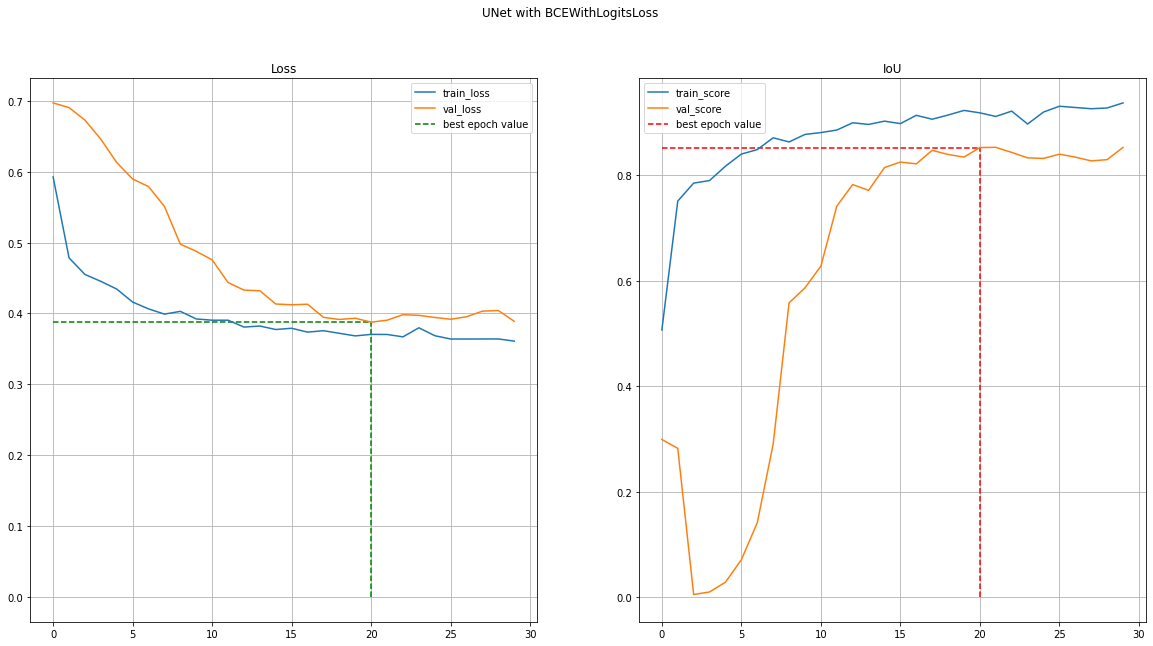

In [ ]:
best_checkpoint = torch.load(unet_SoftBCE_history['model_name'])


     

UNet_SoftBCE.load_state_dict(best_checkpoint['model_state'])
unet_bce_test_iou = score_model(UNet_SoftBCE, iou_pytorch, data_ts).cpu().item()
unet_SoftBCE_history['test'] = unet_bce_test_iou


     

min_val_loss, max_val_iou, best_epoch = best_checkpoint['model_loss'], best_checkpoint['model_iou'], best_checkpoint['epoch']
print(f"Best UNet BCE val loss: {min_val_loss}")
print(f"Best UNet BCE val IoU: {max_val_iou}")
print(f"Best UNet BCE epoch: {best_epoch}")
print(f"Best UNet BCE test IoU: {unet_bce_test_iou}")

plot_history(unet_SoftBCE_history, min_val_loss, max_val_iou, best_epoch, 'UNet with BCEWithLogitsLoss')

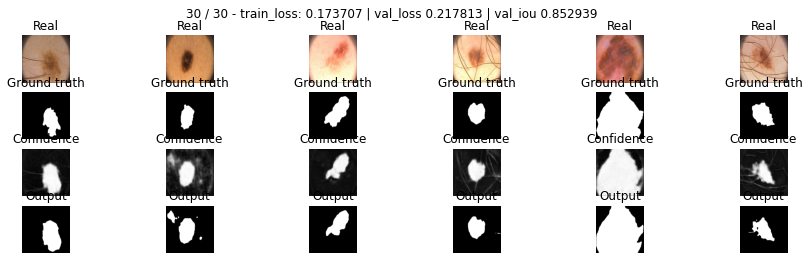

In [ ]:
max_epochs = 30
UNet_BCE = UNet().to(device)

optimizer = optim.Adam(UNet_BCE.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = BCEWithLogitsLoss()
unet_BCE_history = train(UNet_BCE, 
                         optimizer, 
                         scheduler,
                         criterion,
                         data_tr, 
                         data_val,
                         max_epochs,
                         device=device,
                         model_name='unet_bce')

Best UNet BCE val loss: 0.21707585453987122
Best UNet BCE val IoU: 0.8521311283111572
Best UNet BCE epoch: 19
Best UNet BCE test IoU: 0.8485721349716187


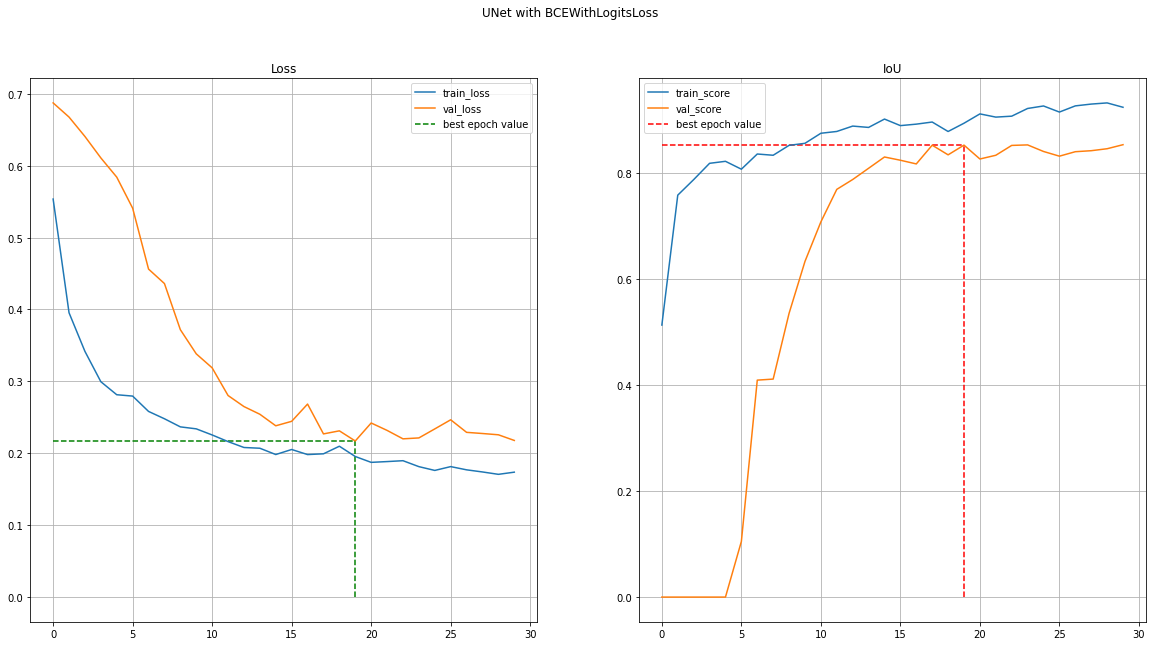

In [ ]:
best_checkpoint = torch.load(unet_BCE_history['model_name'])


     

UNet_BCE.load_state_dict(best_checkpoint['model_state'])
unet_bce_test_iou = score_model(UNet_BCE, iou_pytorch, data_ts).cpu().item()
unet_BCE_history['test'] = unet_bce_test_iou


     

min_val_loss, max_val_iou, best_epoch = best_checkpoint['model_loss'], best_checkpoint['model_iou'], best_checkpoint['epoch']
print(f"Best UNet BCE val loss: {min_val_loss}")
print(f"Best UNet BCE val IoU: {max_val_iou}")
print(f"Best UNet BCE epoch: {best_epoch}")
print(f"Best UNet BCE test IoU: {unet_bce_test_iou}")

plot_history(unet_BCE_history, min_val_loss, max_val_iou, best_epoch, 'UNet with BCEWithLogitsLoss')

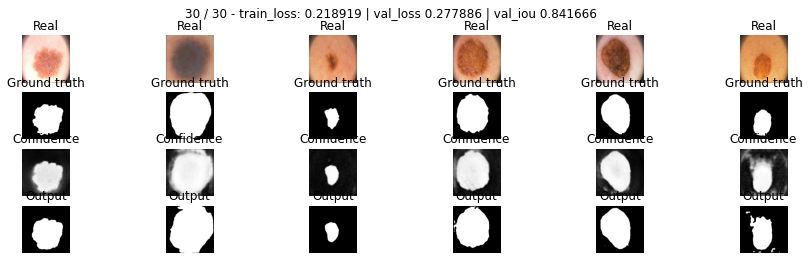

In [ ]:

UNet_Dice = UNet().to(device)

optimizer = optim.Adam(UNet_Dice.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = DiceLoss()
unet_dice_history = train(UNet_Dice, 
                         optimizer, 
                         scheduler,
                         criterion,
                         data_tr, 
                         data_val,
                         max_epochs,
                         device=device,
                         model_name='unet_dice')

Best UNet Dice val loss: 0.26282718777656555
Best UNet Dice val IoU: 0.8680160343647003
Best UNet Dice epoch: 13
Best UNet Dice test IoU: 0.8560606241226196


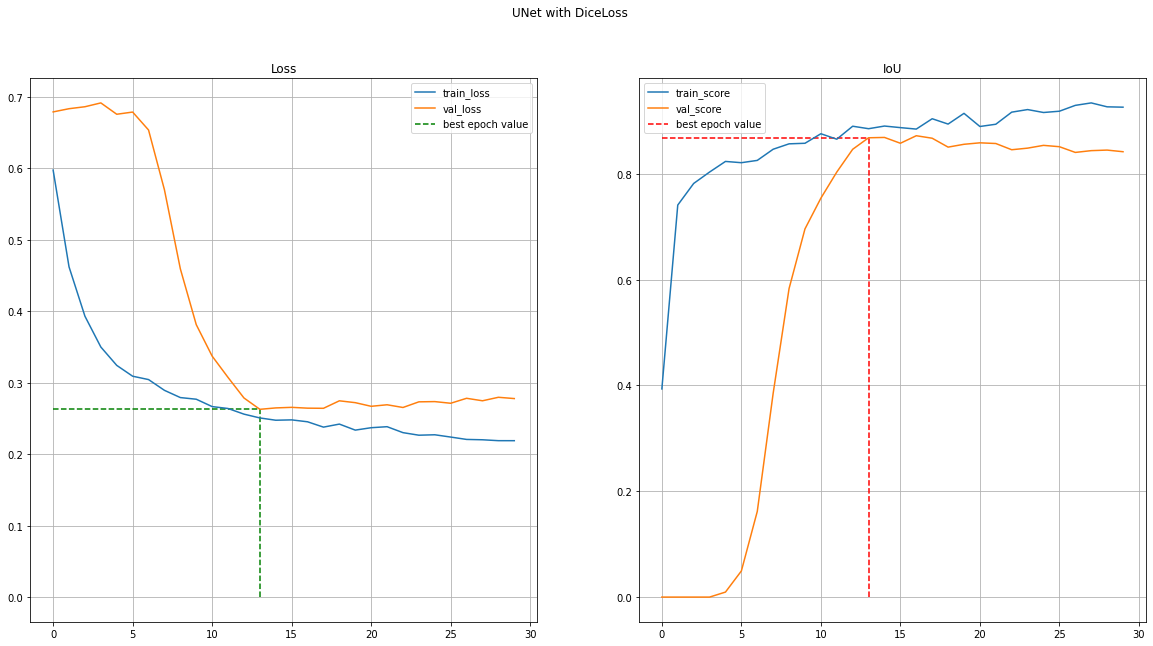

In [ ]:
best_checkpoint = torch.load(unet_dice_history['model_name'])


     

UNet_Dice.load_state_dict(best_checkpoint['model_state'])
unet_dice_test_iou = score_model(UNet_Dice, iou_pytorch, data_ts).cpu().item()
unet_dice_history['test'] = unet_dice_test_iou


     

min_val_loss, max_val_iou, best_epoch = best_checkpoint['model_loss'], best_checkpoint['model_iou'], best_checkpoint['epoch']
print(f"Best UNet Dice val loss: {min_val_loss}")
print(f"Best UNet Dice val IoU: {max_val_iou}")
print(f"Best UNet Dice epoch: {best_epoch}")
print(f"Best UNet Dice test IoU: {unet_dice_test_iou}")


plot_history(unet_dice_history, min_val_loss, max_val_iou, best_epoch, 'UNet with DiceLoss')

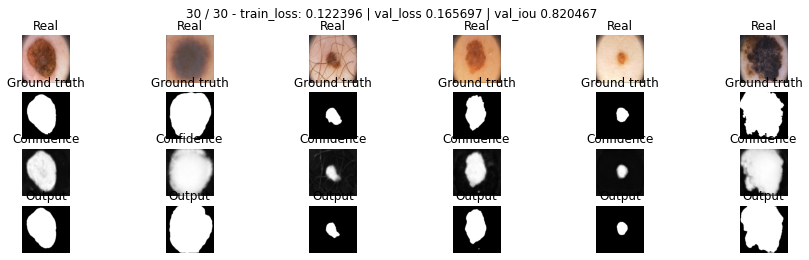

In [ ]:
UNet_Focal = UNet().to(device)

optimizer = optim.Adam(UNet_Focal.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = FocalLoss()
unet_focal_history = train(UNet_Focal, 
                            optimizer, 
                            scheduler,
                            criterion,
                            data_tr, 
                            data_val,
                            max_epochs,
                            device=device,
                            model_name='unet_focal')

Best UNet Focal val loss: 0.16042515635490417
Best UNet Focal val IoU: 0.8339420855045319
Best UNet Focal epoch: 28
Best UNet Focal test IoU: 0.82819664478302


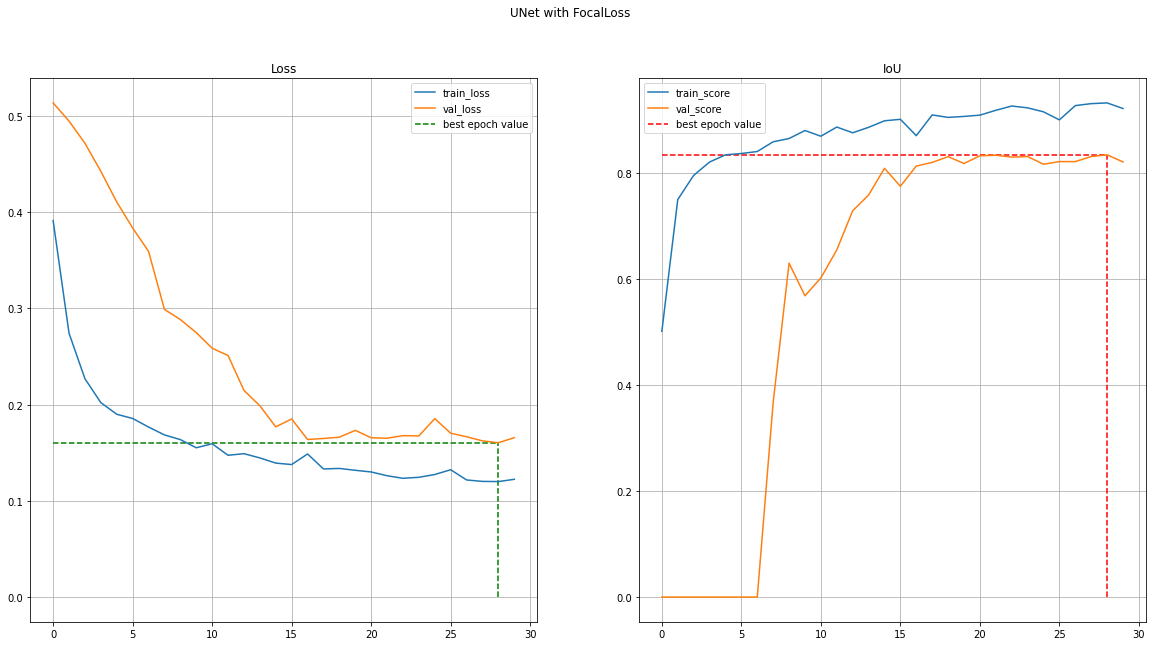

In [ ]:
best_checkpoint = torch.load(unet_focal_history['model_name'])
UNet_Focal.load_state_dict(best_checkpoint['model_state'])
unet_focal_test_iou = score_model(UNet_Focal, iou_pytorch, data_ts).cpu().item()
unet_focal_history['test'] = unet_focal_test_iou


     

min_val_loss, max_val_iou, best_epoch = best_checkpoint['model_loss'], best_checkpoint['model_iou'], best_checkpoint['epoch']
print(f"Best UNet Focal val loss: {min_val_loss}")
print(f"Best UNet Focal val IoU: {max_val_iou}")
print(f"Best UNet Focal epoch: {best_epoch}")
print(f"Best UNet Focal test IoU: {unet_focal_test_iou}")

plot_history(unet_focal_history, min_val_loss, max_val_iou, best_epoch, 'UNet with FocalLoss')

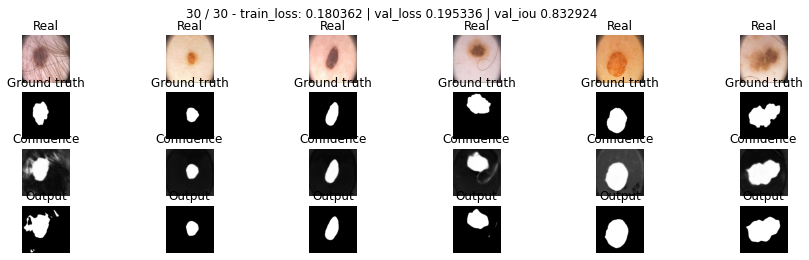

In [ ]:
max_epochs = 30
UNet_Jaccard = UNet().to(device)

optimizer = optim.Adam(UNet_Jaccard.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion =  JaccardLoss()
UNet_Jaccard_history = train(UNet_Jaccard, 
                           optimizer, 
                           scheduler,
                           criterion,
                           data_tr, 
                           data_val,
                           max_epochs,
                           device=device,
                           model_name='segnet_softbce')

Best UNet_Jaccard val loss: 0.19143378734588623
Best UgNet_Jaccard val IoU: 0.8279704749584198
Best UNet_Jaccard epoch: 27
Best UNet_Jaccard test IoU: 0.8578174114227295


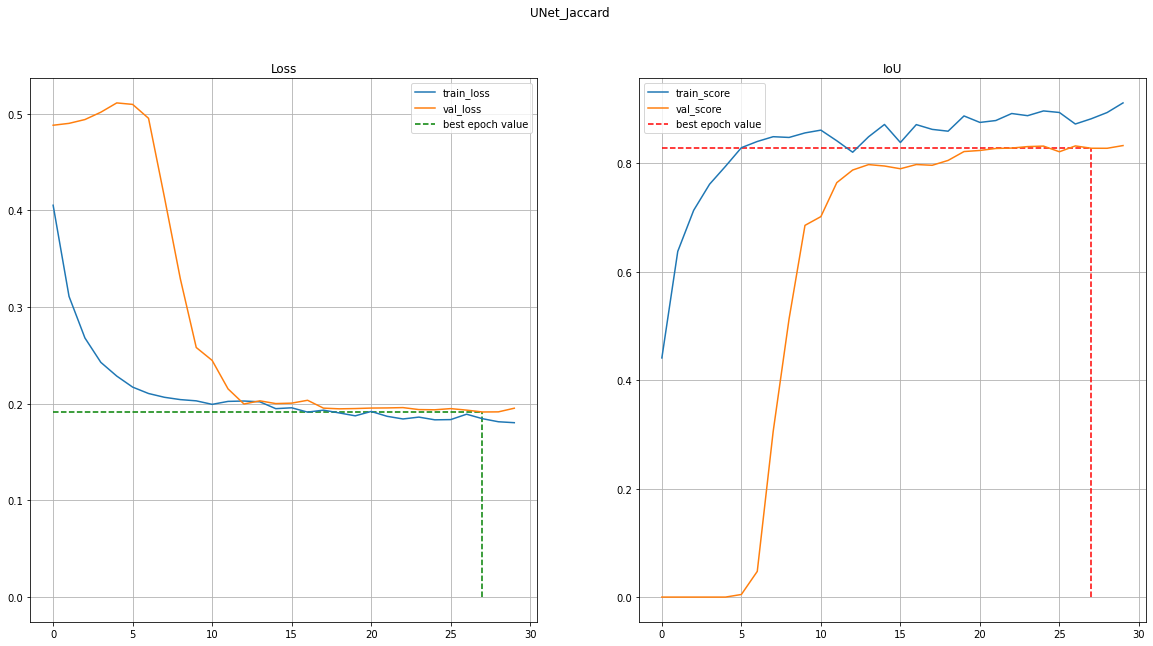

In [ ]:
best_checkpoint = torch.load(UNet_Jaccard_history['model_name'])

UNet_Jaccard.load_state_dict(best_checkpoint['model_state'])
unet_jacc_test_iou = score_model(UNet_Jaccard, iou_pytorch, data_ts).cpu().item()
UNet_Jaccard_history['test'] = unet_jacc_test_iou


     

min_val_loss, max_val_iou, best_epoch = best_checkpoint['model_loss'], best_checkpoint['model_iou'], best_checkpoint['epoch']
print(f"Best UNet_Jaccard val loss: {min_val_loss}")
print(f"Best UgNet_Jaccard val IoU: {max_val_iou}")
print(f"Best UNet_Jaccard epoch: {best_epoch}")
print(f"Best UNet_Jaccard test IoU: {unet_jacc_test_iou}")

plot_history(UNet_Jaccard_history, min_val_loss, max_val_iou, best_epoch, 'UNet_Jaccard')

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


# UNET2

In [ ]:
  class UNet2(UNet):
    def __init__(self):
        super().__init__()

        # encoder
        self.pool0 = nn.Conv2d(64, 64, kernel_size=2, stride=2)  # 256 -> 128
        self.pool1 = nn.Conv2d(128, 128, kernel_size=2, stride=2)  # 128 -> 64  
        self.pool2 = nn.Conv2d(256, 256, kernel_size=2, stride=2)  # 64 -> 32  


        self.bottleneck_pool = nn.Conv2d(512, 512, kernel_size=2, stride=2)  # 32 -> 16 
        self.bottleneck_upconv = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)  # 16 -> 32
        
        # decoder
        self.upsample1 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2) # 32 -> 64
        self.upsample2 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)  # 64 -> 128
        self.upsample3 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)  # 128 -> 256


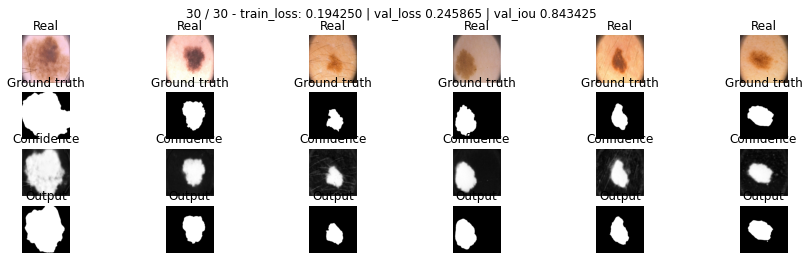

In [ ]:
max_epochs = 30


UNet2_BCE = UNet2().to(device)

optimizer = optim.Adam(UNet2_BCE.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = BCEWithLogitsLoss()
unet2_bce_history = train(UNet2_BCE, 
                          optimizer, 
                          scheduler,
                          criterion,
                          data_tr, 
                          data_val,
                          max_epochs,
                          device=device,
                          model_name='unet2_bce')


Best UNet2 BCE val loss: 0.24058480560779572
Best UNet2 BCE val IoU: 0.8404092490673065
Best UNet2 BCE epoch: 27
Best UNet2 BCE test IoU: 0.8051595091819763


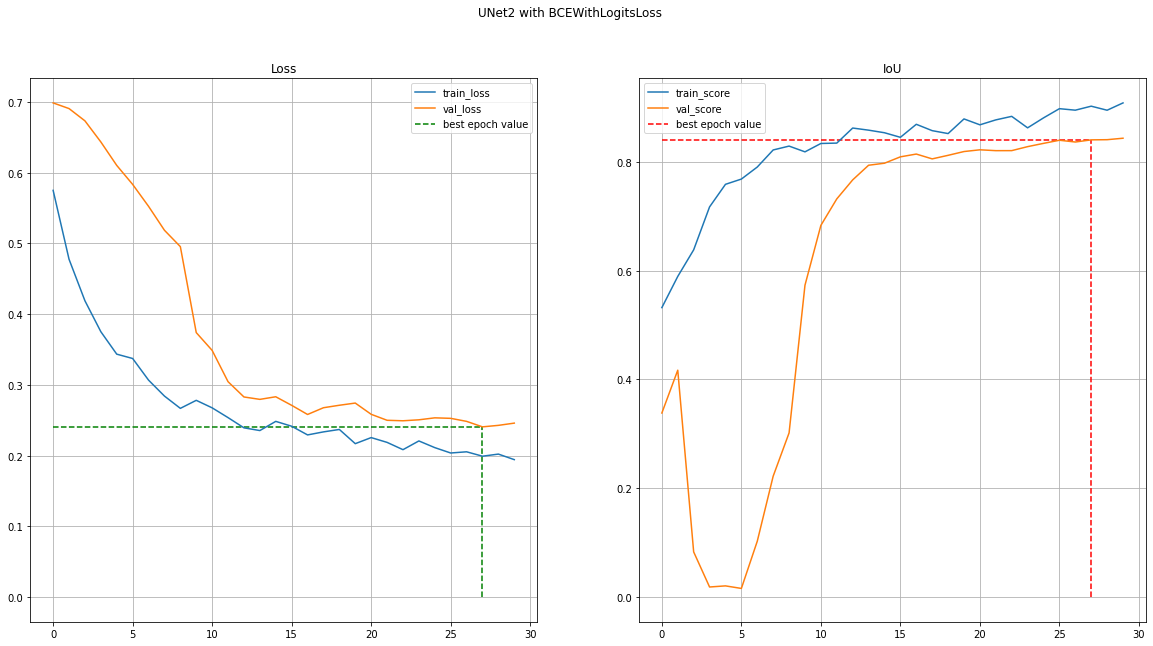

In [ ]:
best_checkpoint = torch.load(unet2_bce_history['model_name'])


     

UNet2_BCE.load_state_dict(best_checkpoint['model_state'])
unet2_bce_test_iou = score_model(UNet2_BCE, iou_pytorch, data_ts).cpu().item()
unet2_bce_history['test'] = unet2_bce_test_iou


     

min_val_loss, max_val_iou, best_epoch = best_checkpoint['model_loss'], best_checkpoint['model_iou'], best_checkpoint['epoch']
print(f"Best UNet2 BCE val loss: {min_val_loss}")
print(f"Best UNet2 BCE val IoU: {max_val_iou}")
print(f"Best UNet2 BCE epoch: {best_epoch}")
print(f"Best UNet2 BCE test IoU: {unet2_bce_test_iou}")



plot_history(unet2_bce_history, min_val_loss, max_val_iou, best_epoch, 'UNet2 with BCEWithLogitsLoss')

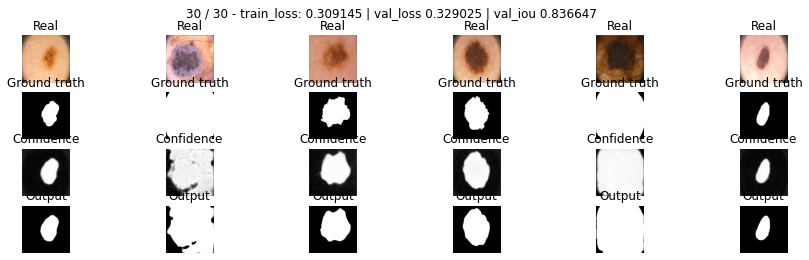

In [ ]:
UNet2_Dice = UNet2().to(device)

optimizer = optim.Adam(UNet2_Dice.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion =   DiceLoss()
unet2_dice_history = train(UNet2_Dice, 
                          optimizer, 
                          scheduler,
                          criterion,
                          data_tr, 
                          data_val,
                          max_epochs,
                          device=device,
                          model_name='unet2_bce')


Best UNet Dice val loss: 0.24058480560779572
Best UNet Dice val IoU: 0.8404092490673065
Best UNet Dice epoch: 27
Best UNet Dice test IoU: 0.8051595091819763


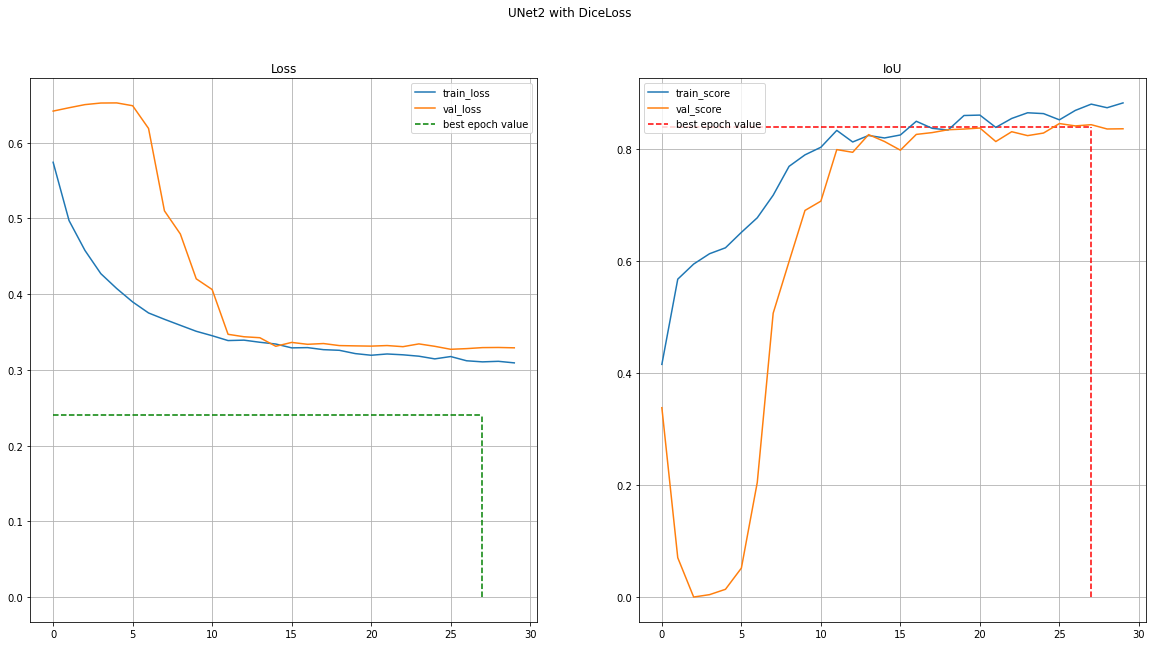

In [ ]:
best_checkpoint = torch.load(unet2_bce_history['model_name'])


     

UNet2_Dice.load_state_dict(best_checkpoint['model_state'])
unet2_dice_test_iou = score_model(UNet2_Dice, iou_pytorch, data_ts).cpu().item()
unet2_dice_history['test'] = unet2_dice_test_iou


     

min_val_loss, max_val_iou, best_epoch = best_checkpoint['model_loss'], best_checkpoint['model_iou'], best_checkpoint['epoch']
print(f"Best UNet Dice val loss: {min_val_loss}")
print(f"Best UNet Dice val IoU: {max_val_iou}")
print(f"Best UNet Dice epoch: {best_epoch}")
print(f"Best UNet Dice test IoU: {unet2_dice_test_iou}")


plot_history(unet2_dice_history, min_val_loss, max_val_iou, best_epoch, 'UNet2 with DiceLoss')

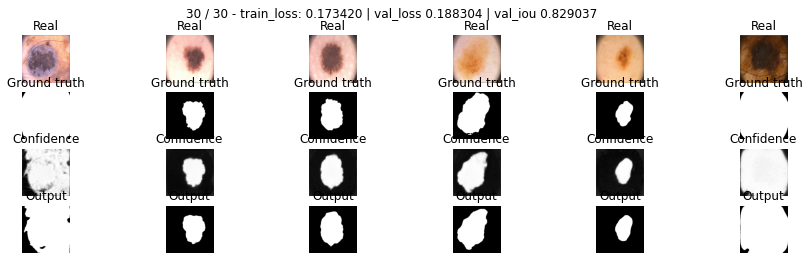

In [ ]:
UNet2_Jaccard = UNet2().to(device)

optimizer = optim.Adam(UNet2_Jaccard.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion =  JaccardLoss()
UNet2_Jaccard_history = train(UNet2_Jaccard, 
                           optimizer, 
                           scheduler,
                           criterion,
                           data_tr, 
                           data_val,
                           max_epochs,
                           device=device,
                           model_name='segnet_softbce')

Best UNet2_Jaccard val loss: 0.18698471784591675
Best UgNet2_Jaccard val IoU: 0.8331998884677887
Best UNet2_Jaccard epoch: 28
Best UNet2_Jaccard test IoU: 0.7954088449478149


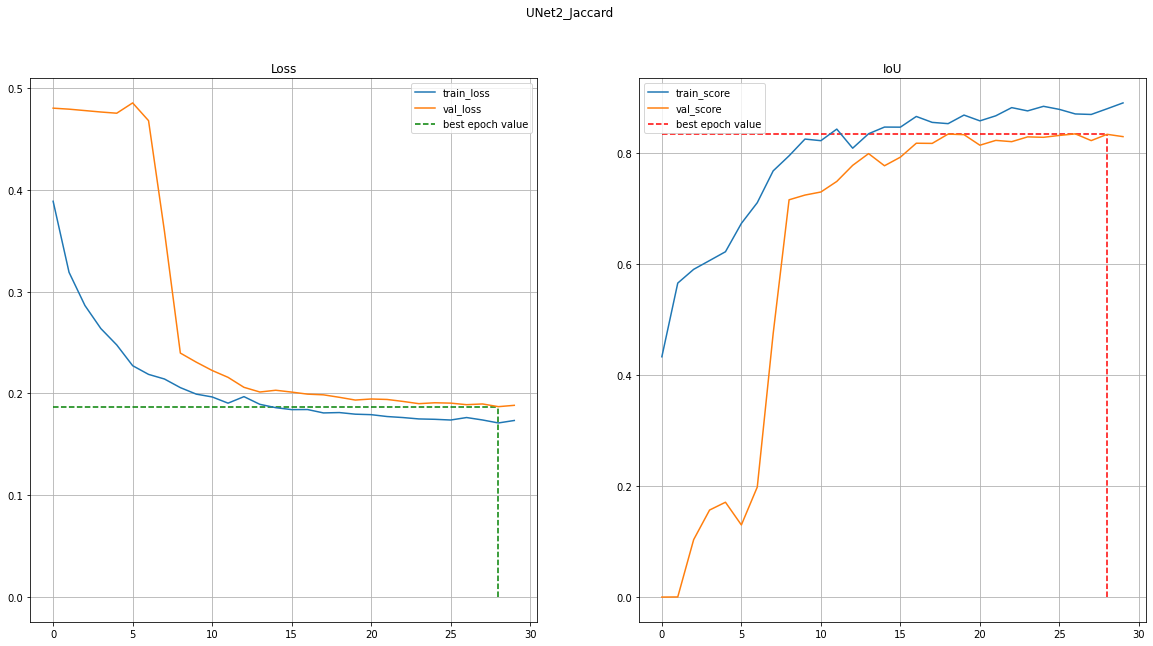

In [ ]:
best_checkpoint = torch.load(UNet2_Jaccard_history['model_name'])

UNet2_Jaccard.load_state_dict(best_checkpoint['model_state'])
unet2_jacc_test_iou = score_model(UNet2_Jaccard, iou_pytorch, data_ts).cpu().item()
UNet2_Jaccard_history['test'] = unet2_jacc_test_iou


     

min_val_loss, max_val_iou, best_epoch = best_checkpoint['model_loss'], best_checkpoint['model_iou'], best_checkpoint['epoch']
print(f"Best UNet2_Jaccard val loss: {min_val_loss}")
print(f"Best UgNet2_Jaccard val IoU: {max_val_iou}")
print(f"Best UNet2_Jaccard epoch: {best_epoch}")
print(f"Best UNet2_Jaccard test IoU: {unet2_jacc_test_iou}")

plot_history(UNet2_Jaccard_history, min_val_loss, max_val_iou, best_epoch, 'UNet2_Jaccard')

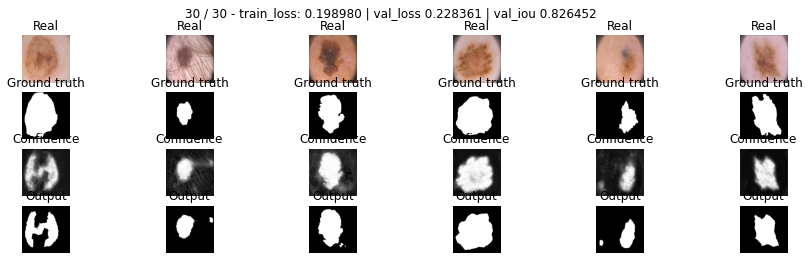

In [ ]:
UNet2_Focal = UNet2().to(device)

optimizer = optim.Adam(UNet2_Focal.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = FocalLoss()
unet2_focal_history = train(UNet2_Focal, 
                            optimizer, 
                            scheduler,
                            criterion,
                            data_tr, 
                            data_val,
                            max_epochs,
                            device=device,
                            model_name='unet2_focal')

Best UNet2 Focal val loss: 0.21877828240394592
Best UNet2 Focal val IoU: 0.8016298711299896
Best UNet2 Focal epoch: 17
Best UNet2 Focal test IoU: 0.827214241027832


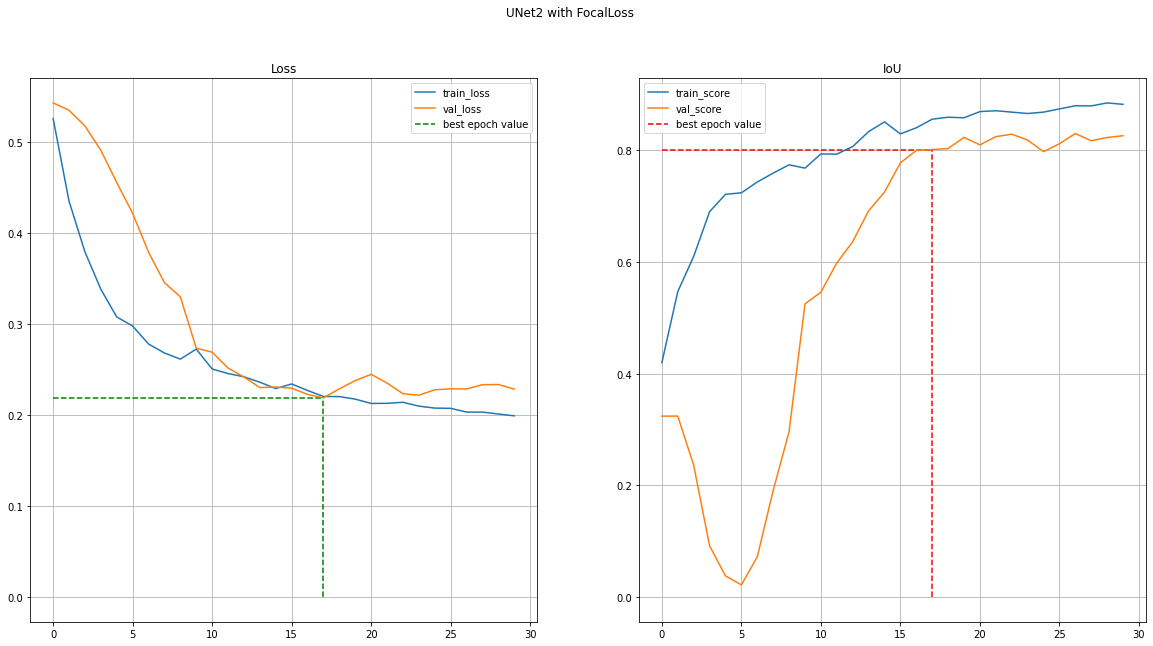

In [ ]:
best_checkpoint = torch.load(unet2_focal_history['model_name'])


     

UNet2_Focal.load_state_dict(best_checkpoint['model_state'])
unet2_focal_test_iou = score_model(UNet2_Focal, iou_pytorch, data_ts).cpu().item()
unet2_focal_history['test'] = unet2_focal_test_iou


     

min_val_loss, max_val_iou, best_epoch = best_checkpoint['model_loss'], best_checkpoint['model_iou'], best_checkpoint['epoch']
print(f"Best UNet2 Focal val loss: {min_val_loss}")
print(f"Best UNet2 Focal val IoU: {max_val_iou}")
print(f"Best UNet2 Focal epoch: {best_epoch}")
print(f"Best UNet2 Focal test IoU: {unet2_focal_test_iou}")

plot_history(unet2_focal_history, min_val_loss, max_val_iou, best_epoch, 'UNet2 with FocalLoss')


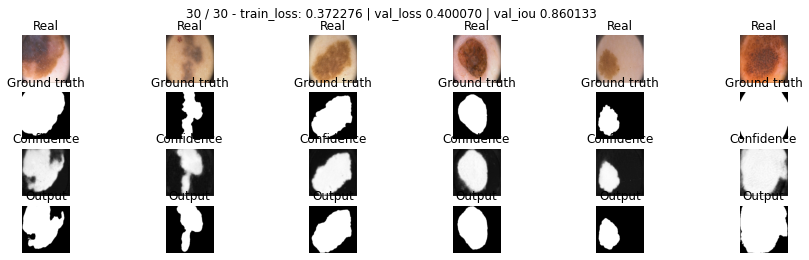

In [ ]:
max_epochs = 30
UNet2_SoftBCE = UNet2().to(device)

optimizer = optim.Adam(UNet2_SoftBCE.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = SoftBCEWithLogitsLoss()
unet2_SoftBCE_history = train(UNet2_SoftBCE, 
                         optimizer, 
                         scheduler,
                         criterion,
                         data_tr, 
                         data_val,
                         max_epochs,
                         device=device,
                         model_name='unet_bce')

Best UNet BCE val loss: 0.4000699818134308
Best UNet BCE val IoU: 0.8601334989070892
Best UNet BCE epoch: 29
Best UNet BCE test IoU: 0.8270737528800964


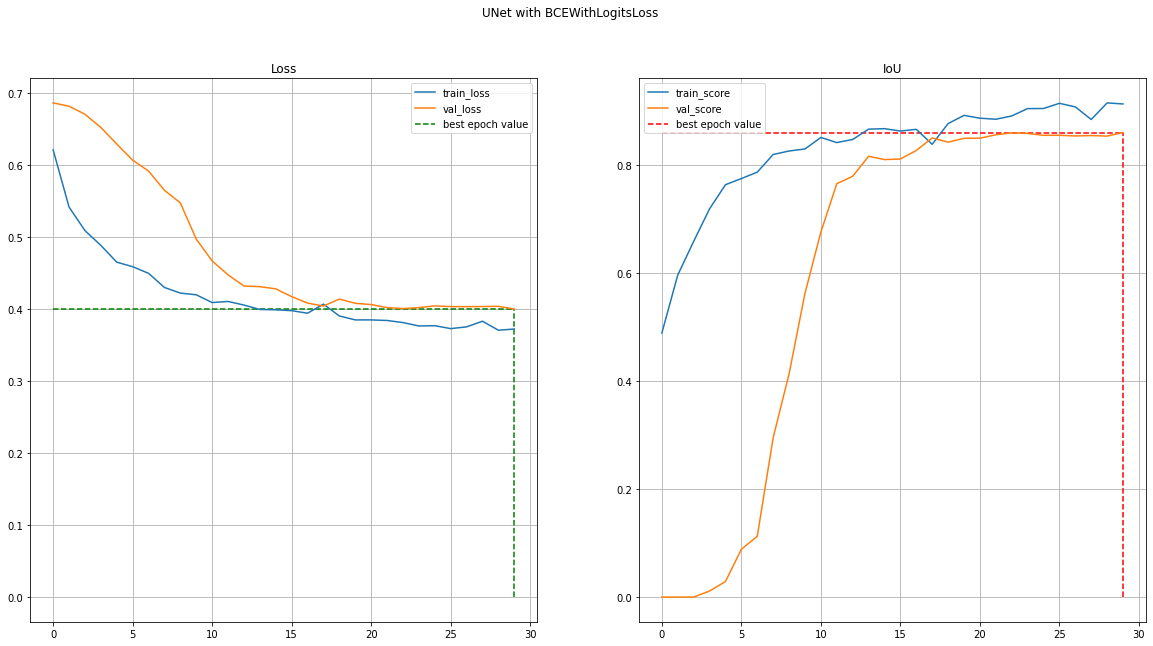

In [ ]:
best_checkpoint = torch.load(unet2_SoftBCE_history['model_name'])


     

UNet2_SoftBCE.load_state_dict(best_checkpoint['model_state'])
unet2_bce_test_iou = score_model(UNet2_SoftBCE, iou_pytorch, data_ts).cpu().item()
unet2_SoftBCE_history['test'] = unet2_bce_test_iou


     

min_val_loss, max_val_iou, best_epoch = best_checkpoint['model_loss'], best_checkpoint['model_iou'], best_checkpoint['epoch']
print(f"Best UNet2 BCE val loss: {min_val_loss}")
print(f"Best UNet2 BCE val IoU: {max_val_iou}")
print(f"Best UNet2 BCE epoch: {best_epoch}")
print(f"Best UNet2 BCE test IoU: {unet2_bce_test_iou}")

plot_history(unet2_SoftBCE_history, min_val_loss, max_val_iou, best_epoch, 'UNet with BCEWithLogitsLoss')

In [ ]:
import seaborn as sns

In [ ]:

def plot_model(history, title: str):
    f, ax = plt.subplots(1, 3, figsize=(24, 10))
    for k in history:
        ax[0].plot(history[k]['val_losses'], label=k)
        ax[1].plot(history[k]['val_iou'], label=k)
    ax[2] = sns.barplot(x=list(history.keys()), y=[i['test'] for i in history.values()])

    ax[0].set_title('Loss')
    ax[1].set_title('val')
    ax[2].set_title('test')
    plt.suptitle(title)
    for col in ax:
        col.grid(True)
        col.legend()

Сделайте вывод, какая из моделей лучше

# Отчет: 


# SegNet

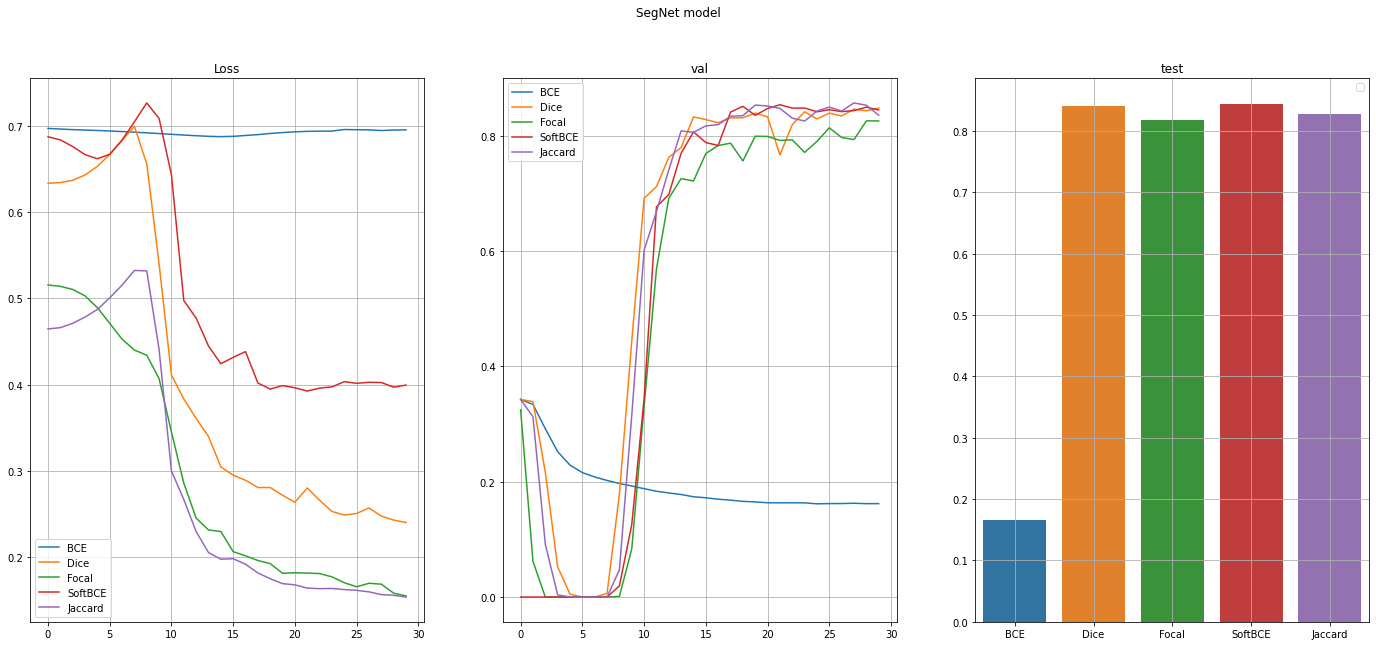

In [ ]:
segnet_losses = {
    'BCE': segnet_bce_history,
    'Dice': segnet_dice_history,
    'Focal': segnet_focal_history,
    'SoftBCE': segnet_softbce_history,
    'Jaccard': segnet_jaccard_history,

}
plot_model(segnet_losses, 'SegNet model')




---


Итак, как мы можем видеть из приведенных выше графиков по лоссу наши функции распределились на три группы - лучшие: *Focal* и  *Jaccard*, середнячки: *Dice* и  *SoftBCE*, а вот с  *BCE* беда. Однако лучшие показатели на тестовой выборке у *SoftBCE* +- на уровне с *Dice*. А вот *Focal* плоховато себя показал как на валидационной, так и на тестовой выборке. Отмечу неплохие показатели *Jaccard* - эту функцию я решил реализовать дополнительно. При обучении уровень *Loss*'ов после 10 эпохи происходит резкий скачок вниз, а к 20-ой эпохе он выходит на плато.

**Топ-3 по кластеру:**


1.   *SoftBCE*
2.   *Dice*
3.   *Jaccard*



---





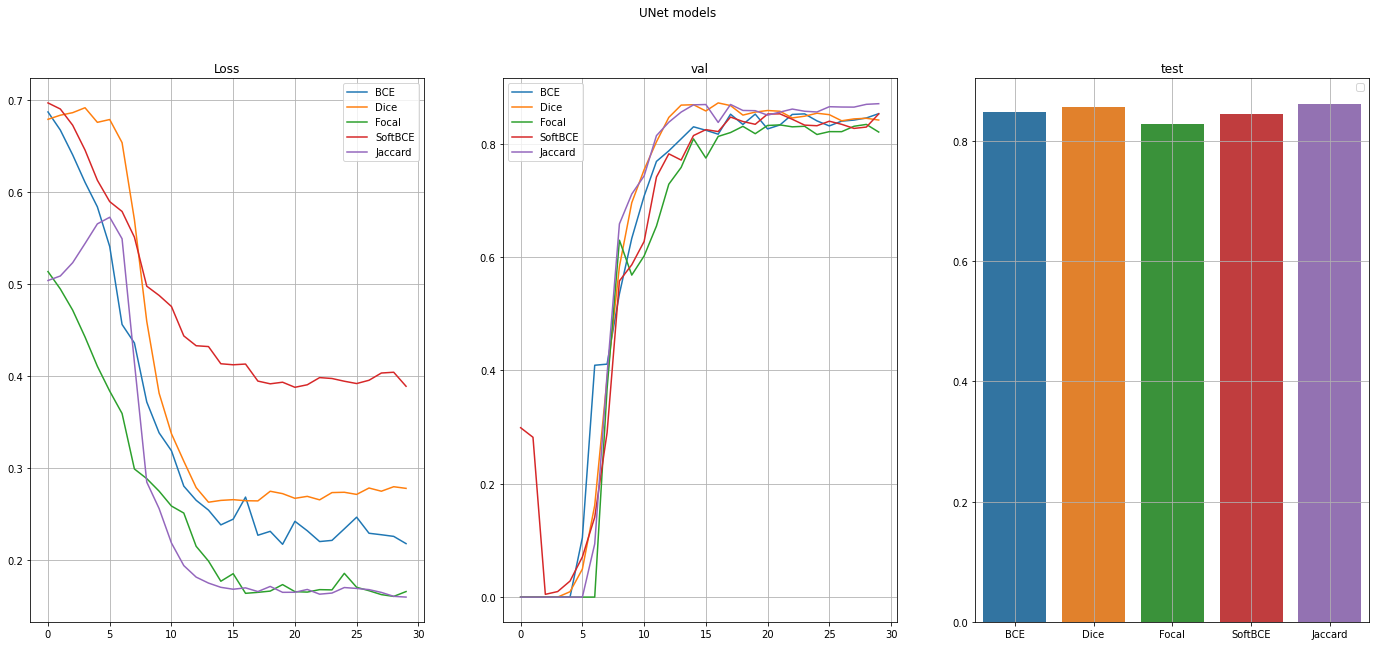

In [ ]:
unet_losses = {
    'BCE': unet_BCE_history,
    'Dice': unet_dice_history,
    'Focal': unet_focal_history,
    'SoftBCE': unet_SoftBCE_history,
    'Jaccard': UNet_Jaccard_history,

}
plot_model(unet_losses, 'UNet models')

# UNet



---


Так, на этой модели с Loss'ами все идентично, разве что *BCE* ожил. Борьба между  *Focal* и  *Jaccard* тут напряженнее. Скачок происходит после 6-7 эпохи, а выход на плато на 15-17.

На валидации лидеры *Dice* и  *Jaccard*, *Focal* снова аутсайдер. На тестовой выборке получены довольно сопоставимые результаты, однако ниже приведу топ)

**Топ-3 по кластеру:**
    
1.   *Jaccard*
2.   *Dice*
3.   *BCE*

Заметим, что по сравнению с прошлой моделью, *Jaccard* поднялся с 3 место на 1.
*Dice* свою позицию сохранил, а вот *BCE* оказалость лучше *SoftBCE* и заняло третью позицию

---



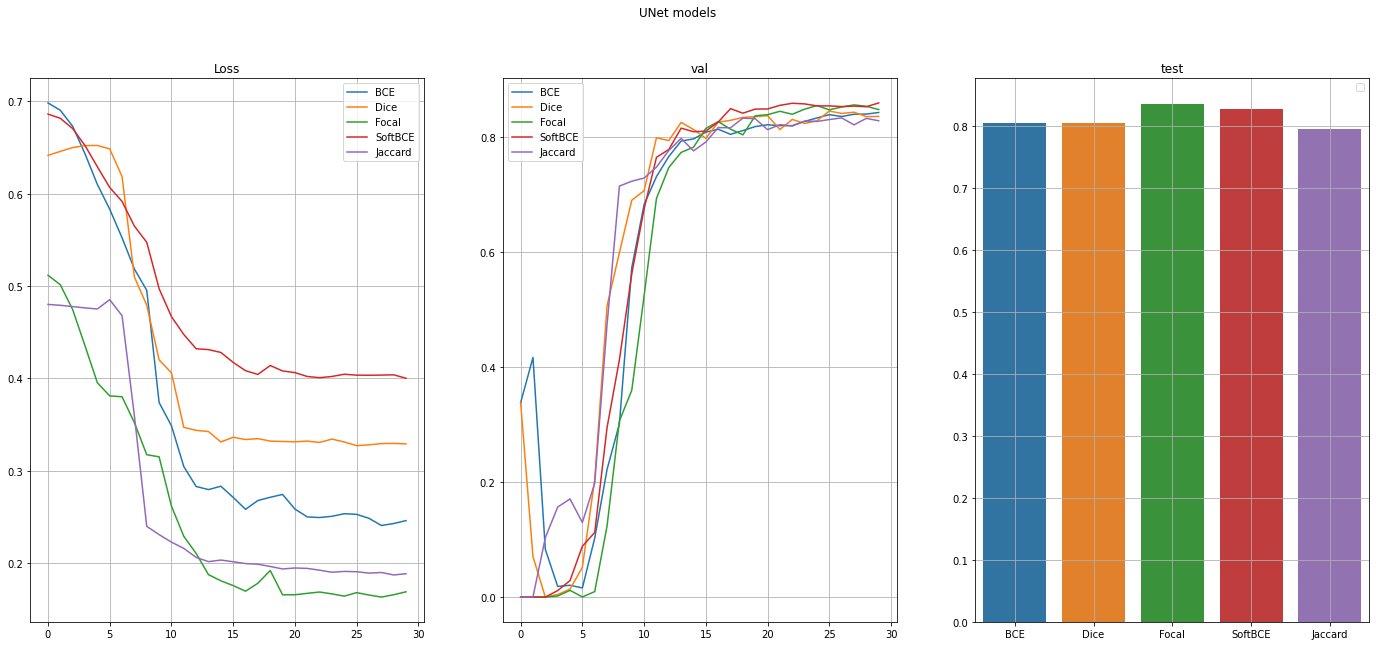

In [ ]:
unet2_losses = {
    'BCE': unet2_bce_history,
    'Dice': unet2_dice_history,
    'Focal': unet2_focal_history,
    'SoftBCE': unet2_SoftBCE_history,
    'Jaccard': UNet2_Jaccard_history,

}
plot_model(unet2_losses, 'UNet models')



---

Напоследок несколько модифицированная версия UNet, в ней я заменил *max-pooling* на *convolutions* с *stride*=2 и *upsampling* на *transpose-convolutions* с *stride*=2.

Распределение функций по Loss'ам неизменное, однако видим, что на вадидационное выборке *Focal* - далеко не аутсайдер - он лидирует наравне с *SoftBCE*, а вот *Jaccard* и *Dice* - уступают.

Резульаты на тестовой выборке на модифицированном UNet ниже чем на исходном варианте и *SegNet* примерно на 0.2, большинство функций еле переступили порог 0.8.

**Топ-3 по кластеру:**
    
1.   *Focal*
2.   *SoftBCE*
3.   *BCE*

Тройка полность измениласть с добавлением некоторых изменений в модель)



---




---
Выбираем по лучшей модели из каждого кластера:
* **SoftBCE** на *SegNet*
* **Jaccard** на *UNet*
* **Focal** на *UNet2*

И выявим лучшую модель!

---

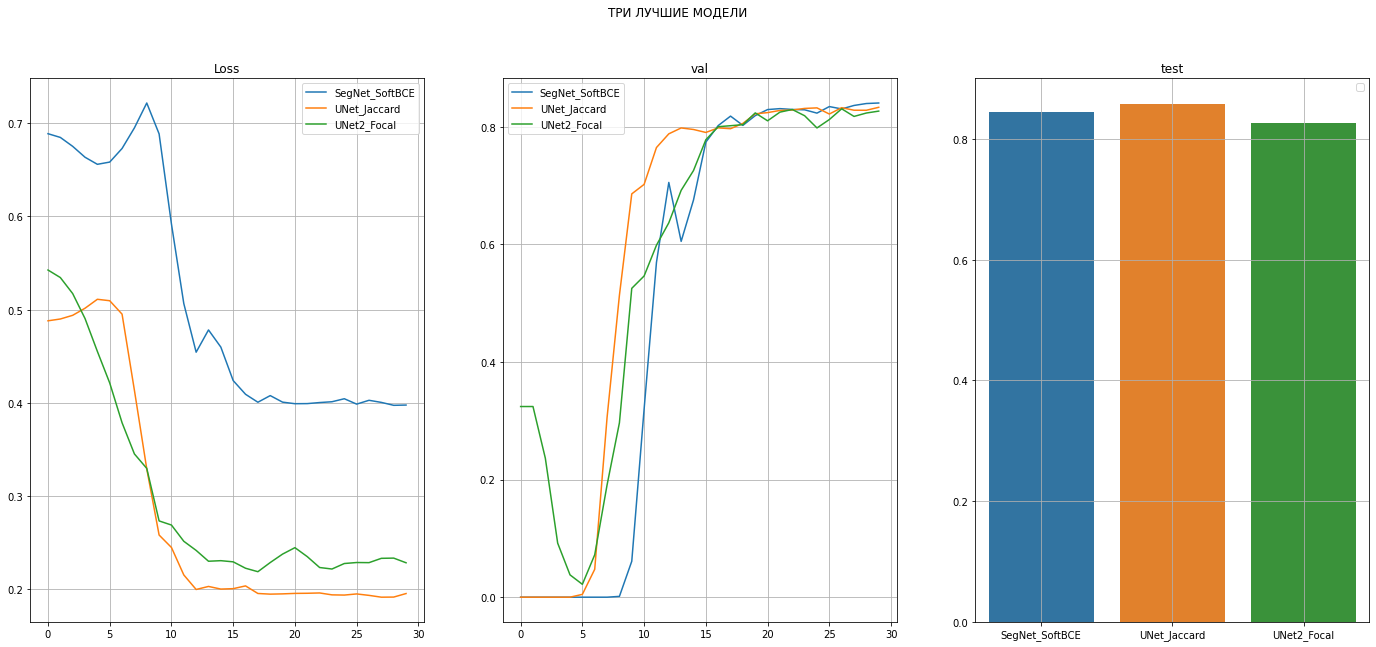

In [ ]:
top_losses = {
    'SegNet_SoftBCE': segnet_softbce_history,
    'UNet_Jaccard': UNet_Jaccard_history,
    'UNet2_Focal': unet2_focal_history,
}
plot_model(top_losses, 'ТРИ ЛУЧШИЕ МОДЕЛИ')


Получаем, что лучшей моделью является **UNet** c функцией **Jaccard**, показавшая лучшие результаты как на валидационной так и на тестовой выборке